In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Metrics JSON at %s is not well-formed" % path)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better. If `max_epoch` is provided, will
    only report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception as e:
            print(e)
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [16]:
def print_profile_losses(condition, max_epoch=None):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_batch_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [20]:
noprior_vals = print_profile_losses("SPI1")

Best profile loss overall:
	Best run: 4
	Best epoch in run: 19
	Associated value: 85.27962607630977
Best epoch in each run:
	Run 1, epoch 16:  86.15
	Run 2, epoch 12:  85.34
	Run 3, epoch 20:  85.61
	Run 4, epoch 19:  85.28
	Run 5, epoch 3:  86.20
All validation profile and prior losses:
1
	108.80 105.72 103.69 103.35 102.36 102.39 102.88 101.81 102.20 101.55 101.48 101.57 101.37 101.70 101.91 101.70 101.30 101.42 101.30 101.21
	 88.49  87.43  86.98  86.68  86.50  86.43  86.45  86.40  86.41  86.28  86.26  86.21  86.20  86.16  86.26  86.15  86.24  86.26  86.16  86.19
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	107.21 104.37 102.30 102.02 100.84 100.78 100.52 100.13 100.46 100.15 100.39  99.76 100.11 100.13 100.31
	 87.42  86.45  86.00  85.79  85.70  85.66  85.50  85.44  85.43  85.39  85.61  85.34  85.39  85.36  85.36
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0

In [18]:
prior_vals = print_profile_losses("SPI1_prior")

Best profile loss overall:
Metrics JSON at /users/amtseng/att_priors/models/trained_models/profile/SPI1_prior/2/metrics.json is not well-formed
	Best run: 1
	Best epoch in run: 12
	Associated value: 85.86045782301161
Best epoch in each run:
	Run 1, epoch 12:  85.86
All validation profile and prior losses:
1
	111.81 108.96 105.71 104.74 103.84 104.37 104.07 103.10 103.85 102.44 102.18 101.74 102.64 102.27 102.83 102.13 102.13 101.68 101.88 102.39
	 88.90  87.60  86.72  86.53  86.38  86.15  86.30  86.07  86.07  85.94  85.94  85.86  85.97  85.94  86.02  85.91  86.02  85.91  85.97  86.20
	0.0518 0.0436 0.0397 0.0372 0.0358 0.0350 0.0339 0.0339 0.0332 0.0328 0.0324 0.0319 0.0316 0.0320 0.0316 0.0311 0.0309 0.0309 0.0303 0.0302


Mean without priors: 85.717049
Mean with priors: 85.860458
nan
nan


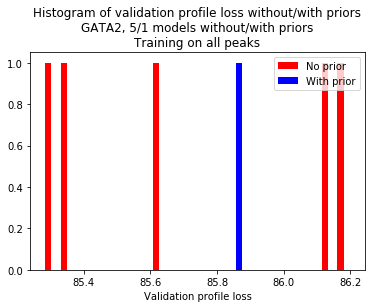

In [21]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss without/with priors"
title += "\nGATA2, %d/%d models without/with priors" % (len(noprior_vals), len(prior_vals))
title += "\nTraining on all peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print(t)
print(p / 2)

In [5]:
def print_binary_losses(condition, max_epoch=None):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_batch_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [12]:
noprior_vals = print_binary_losses("SPI1")

Best validation loss overall:
	Best run: 2
	Best epoch in run: 2
	Associated value: 0.2685592677134968
Best epoch in each run:
	Run 1, epoch 2:  0.272
	Run 2, epoch 2:  0.269
	Run 3, epoch 2:  0.271
	Run 4, epoch 2:  0.269
	Run 5, epoch 2:  0.275
	Run 6, epoch 2:  0.274
	Run 7, epoch 2:  0.270
	Run 8, epoch 2:  0.272
	Run 9, epoch 1:  0.282
	Run 10, epoch 2:  0.279
	Run 11, epoch 2:  0.277
All validation profile and prior losses:
1
	 0.272  0.272  0.277  0.290  0.304
	 0.272  0.272  0.277  0.290  0.304
	 0.000  0.000  0.000  0.000  0.000
2
	 0.274  0.269  0.279  0.290  0.308
	 0.274  0.269  0.279  0.290  0.308
	 0.000  0.000  0.000  0.000  0.000
3
	 0.276  0.271  0.278  0.290  0.307
	 0.276  0.271  0.278  0.290  0.307
	 0.000  0.000  0.000  0.000  0.000
4
	 0.271  0.269  0.278  0.293  0.303
	 0.271  0.269  0.278  0.293  0.303
	 0.000  0.000  0.000  0.000  0.000
5
	 0.282  0.275  0.279  0.291  0.307
	 0.282  0.275  0.279  0.291  0.307
	 0.000  0.000  0.000  0.000  0.000
6
	 0.278  0.274

In [13]:
prior_vals = print_binary_losses("SPI1_prior")

Best validation loss overall:
	Best run: 3
	Best epoch in run: 7
	Associated value: 0.2633235939465568
Best epoch in each run:
	Run 1, epoch 7:  0.267
	Run 2, epoch 5:  0.271
	Run 3, epoch 7:  0.263
All validation profile and prior losses:
1
	 0.348  0.331  0.309  0.303  0.301  0.296  0.297  0.299  0.297  0.310  0.306  0.309  0.312  0.321
	 0.309  0.298  0.280  0.275  0.268  0.268  0.267  0.268  0.268  0.279  0.278  0.281  0.285  0.291
	 0.039  0.034  0.029  0.027  0.033  0.028  0.030  0.031  0.029  0.031  0.028  0.028  0.027  0.030
2
	 0.333  0.311  0.313  0.316  0.301  0.303  0.305  0.316
	 0.299  0.280  0.282  0.278  0.271  0.272  0.277  0.283
	 0.035  0.031  0.031  0.038  0.030  0.031  0.028  0.033
3
	 0.353  0.351  0.310  0.313  0.318  0.297  0.292  0.313  0.299  0.306  0.314  0.332
	 0.315  0.318  0.280  0.278  0.282  0.266  0.263  0.282  0.272  0.279  0.288  0.300
	 0.038  0.033  0.030  0.036  0.036  0.031  0.029  0.031  0.027  0.027  0.026  0.031


2.390896686142628
0.017039769454629528


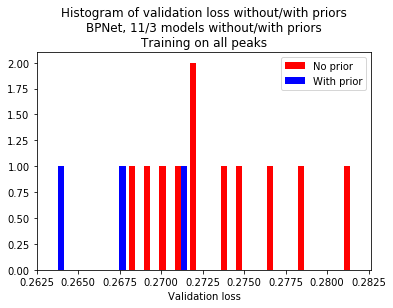

In [14]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation loss without/with priors"
title += "\nBPNet, %d/%d models without/with priors" % (len(noprior_vals), len(prior_vals))
title += "\nTraining on all peaks"
plt.title(title)
plt.xlabel("Validation loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)